In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# Préparation des données

In [3]:
# Establish a connection to the database
conn = psycopg2.connect(
    host="localhost",
    database="ProjetBI",
    user="postgres",
    password="marwa"
)

# Create a cursor object
cur = conn.cursor()

# Execute the SQL query
cur.execute("SELECT stats.\"Job_Duration\", stats.\"Data_Volume\", (select count(\"Component_PK\") from public.\"DimJob\" join public.\"DimComponent\" on(public.\"DimJob\".\"Job_PK\" = public.\"DimComponent\".\"Job_FK\") where \"Job_PK\"=stats.\"Job_FK\" group by \"Job_Code\") as \"Nbr_Components\" FROM public.\"FactStats\" stats")
# Fetch all the rows as a list of tuples
rows = cur.fetchall()

# Convert the list of tuples to a pandas DataFrame
df = pd.DataFrame(rows, columns=["Job_Duration","Data_Volume","Nbr_Components"])
print(df)

df.to_csv("ziednoob1.csv",sep="|", index=False)


       Job_Duration  Data_Volume  Nbr_Components
0             33447        39387               9
1             33447        39600               9
2             33447        39593               9
3             33447        39680               9
4             33447        41401               9
...             ...          ...             ...
11843         20993         3553               5
11844         20993         3554               5
11845         20993         3512               5
11846         20993         3482               5
11847         20993         3458               5

[11848 rows x 3 columns]


<Axes: >

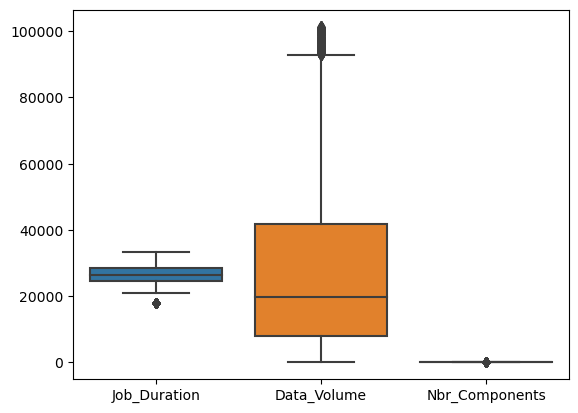

In [36]:
# Tracer un diagramme en boîte pour chaque variable
sns.boxplot(data=df)

In [37]:
# Calculer l'IQR pour chaque colonne
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Identifier les valeurs aberrantes pour chaque colonne
outliers_count = (df['Data_Volume'] < (Q1['Data_Volume'] - 1.5 * IQR['Data_Volume'])) | (df['Data_Volume'] > (Q3['Data_Volume'] + 1.5 * IQR['Data_Volume']))
outliers_duration = (df['Job_Duration'] < (Q1['Job_Duration'] - 1.5 * IQR['Job_Duration'])) | (df['Job_Duration'] > (Q3['Job_Duration'] + 1.5 * IQR['Job_Duration']))

# Supprimer les valeurs aberrantes du dataframe
df = df[~(outliers_count | outliers_duration)]

<Axes: >

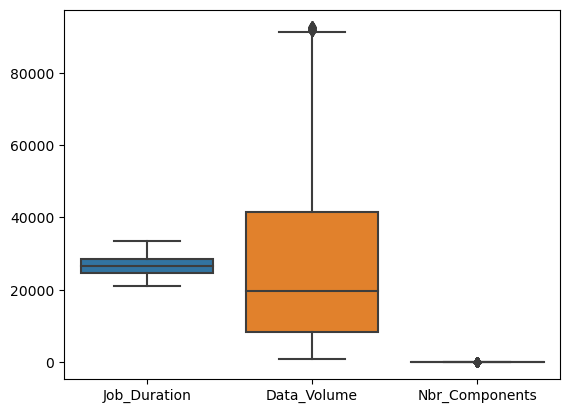

In [38]:
# Tracer un diagramme en boîte pour chaque variable
sns.boxplot(data=df)

In [39]:
# normalize the data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
print(df)


# Séparer les données en variables d'entrée (X) et variable de sortie (y)
X = df[['Data_Volume', 'Nbr_Components']]
y = df['Job_Duration']


# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

      Job_Duration  Data_Volume  Nbr_Components
0              1.0     0.418174             1.0
1              1.0     0.420495             1.0
2              1.0     0.420419             1.0
3              1.0     0.421367             1.0
4              1.0     0.440121             1.0
...            ...          ...             ...
9880           0.0     0.027689             0.2
9881           0.0     0.027700             0.2
9882           0.0     0.027243             0.2
9883           0.0     0.026916             0.2
9884           0.0     0.026654             0.2

[9885 rows x 3 columns]


# Visualisation des données du train

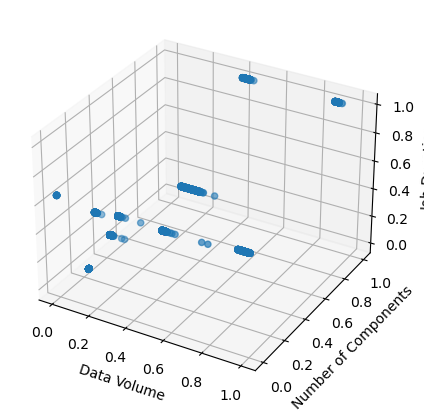

In [40]:
# create a scatter plot of the training data

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['Data_Volume'], X_train['Nbr_Components'], y_train)
ax.set_xlabel('Data Volume')
ax.set_ylabel('Number of Components')
ax.set_zlabel('Job Duration')
plt.show()

# Création du modèle

In [41]:
# Créer le modèle de réseau de neurones
model = Sequential()
model.add(Dense(32, input_dim=2, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compiler le modèle
model.compile(loss='mse', optimizer='adam')

# Entraîner le modèle
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                96        
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
None
62/62 [==============================] - 0s 532us/step


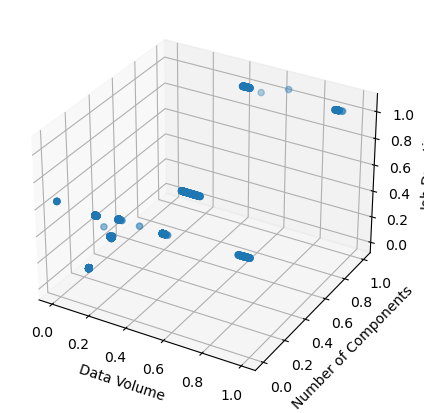

In [42]:
print(model.summary())



# Predict the values of y for X_test using the trained model
y_pred = model.predict(X_test)



# create a scatter plot of the test data

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test['Data_Volume'], X_test['Nbr_Components'], y_pred)
ax.set_xlabel('Data Volume')
ax.set_ylabel('Number of Components')
ax.set_zlabel('Job Duration')
plt.show()

In [43]:
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

# Calculate R²
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)


Mean Squared Error: 1.8194598689036476e-05
Root Mean Squared Error: 0.0042655127111563594
R² Score: 0.99976040396483


D'après les résultats obtenus, le modèle de réseaux de neurones semble être plus performant que le modèle de régression linéaire multiple pour prédire la variable Job_Duration à partir des variables explicatives Data_Volume et Nbr_Components. En effet, le R² du modèle de régression linéaire est de 0.86 et son MSE est de 0.01, tandis que le modèle de réseaux de neurones a un R² de 0.99 et un MSE de 1.8e-05, ce qui est nettement meilleur. Cela suggère que le modèle de réseaux de neurones est mieux capable de capturer les relations complexes entre les variables et de généraliser à de nouvelles données. 